In [1]:
import pandas as pd
import numpy as np
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import json
from nltk import word_tokenize

from utils import create_windowed_dataset, get_penn_treebank_tags

2022-10-15 15:55:30.465719: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-15 15:55:30.473276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-15 15:55:30.473292: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
CHECKPOINT_DIR = 'data/model/pos_checkpoint'
sequence_length = 5 # centre word, 2 before and 2 after
UNK_WORD = '<UNK_WORD>'

In [8]:
train = pd.read_csv('data/WSJ_02-21.pos', sep='\t', header=0, names=['word', 'pos'])
train.head()

,word,pos
0,an,DT
1,Oct.,NNP
2,19,CD
3,review,NN
4,of,IN


In [9]:
# find most common pos to apply to unk words in feature creation
MOST_COMMON_POS = Counter(train['pos']).most_common(1)

In [10]:
# Strip some non pos tags from the input data
tidy = get_penn_treebank_tags()

tags_for_removal = set(train.pos.values)- set(tidy.keys())
print(f'tags in training, but not in the original treebank set: {tags_for_removal}')
train = train[train['pos'].map(lambda x: x not in tags_for_removal)]

FileNotFoundError: [Errno 2] No such file or directory: 'data/penn_treebank.txt'

In [8]:
input_data = []
for tup in train.itertuples(index=False, name=None):
    input_data.append(tup)
input_data[:5]

[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')]

In [9]:
train_matrix = create_windowed_dataset(input_data, sequence_length, mode='train')
train_matrix[:5]

[[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')],
 [('Oct.', 'NNP'),
  ('19', 'CD'),
  ('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT')],
 [('19', 'CD'),
  ('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN')],
 [('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN'),
  ('at', 'IN')],
 [('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN'),
  ('at', 'IN'),
  ('Chicago', 'NNP')]]

In [10]:
suffixes = []
for item in set(train['word']):
    suffixes.append(item[-3:])
    
initial_letters = []
for item in set(train['word']):
    initial_letters.append(item[0])
    
pos_vocab = set(train['pos'])
index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = {v:k for k, v in index_to_pos.items()}



word_vocab = set([UNK_WORD])
word_vocab.update(train['word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

word_vocab.update(initial_letters)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = defaultdict(None, {v:k for k, v in index_to_word.items()})

print(len(word_vocab), len(pos_vocab))

44364
47525
47546
47546 36


In [11]:
# For each word in the vocab determine the most common pos tag
winners = defaultdict()

for row in Counter(list(train.itertuples(index=False, name=None))):
    if row[0] not in winners:
        winners[row[0]] = row[1]
    elif winners[row[0]]< row[1]:
        winners[row[0]] = row[1]
        
print(f'There are {len(winners)} tuples in the dict')

for key in list(winners.keys())[:5]:
    print(key, winners[key])

There are 44363 tuples in the dict
an DT
Oct. NNP
19 CD
review VBP
of RP


In [30]:
winners

defaultdict(None,
            {'an': 'DT',
             'Oct.': 'NNP',
             '19': 'CD',
             'review': 'VBP',
             'of': 'RP',
             'The': 'VB',
             'Misanthrope': 'NN',
             'at': 'RP',
             'Chicago': 'NNP',
             "'s": 'VBZ',
             'Goodman': 'NNP',
             'Theatre': 'NNP',
             'Revitalized': 'VBN',
             'Classics': 'NNS',
             'Take': 'VBP',
             'the': 'VBP',
             'Stage': 'NNP',
             'in': 'RP',
             'Windy': 'NNP',
             'City': 'NNP',
             'Leisure': 'NNP',
             '&': 'SYM',
             'Arts': 'NNS',
             'role': 'NN',
             'Celimene': 'NNP',
             'played': 'VBN',
             'by': 'RP',
             'Kim': 'NNP',
             'Cattrall': 'NNP',
             'was': 'VBD',
             'mistakenly': 'RB',
             'attributed': 'VBN',
             'to': 'TO',
             'Christina': 'NNP',
   

In [39]:
import pickle
pickle.dump(word_to_index, open('data/word_to_index.pk', 'wb'))
pickle.dump(pos_to_index, open('data/pos_to_index.pk', 'wb'))
pickle.dump(index_to_pos, open('data/index_to_pos.pk', 'wb'))
pickle.dump(winners, open('data/winners.pk', 'wb'))

In [12]:
# Dump the dictionaries for use in the js

with open('jq/word_to_index.json', 'wt') as f:
    f.write(json.dumps(word_to_index))
    
with open('jq/pos_to_index.json', 'wt') as f:
    f.write(json.dumps(pos_to_index))
    
with open('jq/index_to_pos.json', 'wt') as f:
    f.write(json.dumps(index_to_pos))    
    
with open('jq/most_common_tag_for_word.json', 'wt') as f:
    f.write(json.dumps(winners))

In [13]:
def build_features(matrix, mode='train'):
    transformed_matrix = []

    for row in matrix:
        features = []

        if mode=='train':
            features.append(pos_to_index[row[1][1]])
            features.append(pos_to_index[row[0][1]])
        else:
            features.append(pos_to_index[winners.get(row[1][0], 'NN')])
            features.append(pos_to_index[winners.get(row[0][0], 'NN')])
            
        features.append(word_to_index.get(row[2][0][-3:], word_to_index[UNK_WORD]))
        features.append(word_to_index.get(row[2][0][0], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[2][0], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[1][0], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[1][0][-3:], word_to_index[UNK_WORD]))

        features.append(word_to_index.get(row[0][0], word_to_index[UNK_WORD]))
        features.append(word_to_index.get(row[3][0], word_to_index[UNK_WORD]))    
        features.append(word_to_index.get(row[3][0][-3:], word_to_index[UNK_WORD]))
        features.append(word_to_index.get(row[4][0], word_to_index[UNK_WORD]))
        
        if mode=='train':
            features.append(pos_to_index[row[2][1]])
        
        transformed_matrix.append(features)
    return transformed_matrix

In [14]:
transformed_matrix = build_features(train_matrix, mode='train')
transformed_matrix[:5]

[[0, 18, 6070, 11402, 6070, 10862, 24605, 45001, 37414, 15668, 25194, 7],
 [7, 0, 15668, 23843, 37414, 6070, 6070, 10862, 25194, 25194, 39425, 16],
 [16, 7, 25194, 47482, 25194, 37414, 15668, 6070, 39425, 39425, 1632, 9],
 [9, 16, 39425, 8390, 39425, 25194, 25194, 37414, 1632, 35703, 18067, 18],
 [18, 9, 35703, 42576, 1632, 39425, 39425, 25194, 18067, 18067, 19358, 16]]

In [13]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=11))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(pos_vocab), activation='sigmoid'))

    return model

In [14]:
model = get_model(len(word_vocab)+len(pos_vocab), 100)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           4758200   
_________________________________________________________________
flatten (Flatten)            (None, 1100)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               110100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                3636      
Total params: 4,871,936
Trainable params: 4,871,936
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalAccuracy()])

In [16]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(pos_vocab))
print(X.shape, y.shape)

max_train_size = 50000

X_train = X[:max_train_size]
X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

y_train = y[:max_train_size]
y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

(832779, 11) (832779, 36)


Epoch 1/10
1563/1563 [==============================] - 64s 41ms/step - loss: 1.1298 - categorical_accuracy: 0.7214 - val_loss: 0.1802 - val_categorical_accuracy: 0.9446
INFO:tensorflow:Assets written to: data/model/pos_checkpoint/assets
Epoch 2/10
1563/1563 [==============================] - 60s 39ms/step - loss: 0.0918 - categorical_accuracy: 0.9739 - val_loss: 0.1873 - val_categorical_accuracy: 0.9436
Epoch 3/10
1563/1563 [==============================] - 60s 39ms/step - loss: 0.0324 - categorical_accuracy: 0.9911 - val_loss: 0.2032 - val_categorical_accuracy: 0.9444


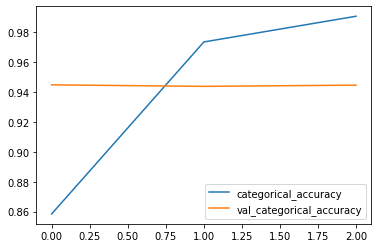

In [17]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
                              tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_DIR, monitor='val_categorical_accuracy',
                                                                save_best_only=True)])

for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [24]:
# Rough test by predicting 1000 test vals against ground truth
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.9306930693069307
0.9353233830845771
0.9435215946843853
0.940149625935162
0.9441117764471058
0.9484193011647255
0.9514978601997147
0.951310861423221
0.9500554938956715


In [71]:
model = tf.keras.models.load_model('data/model/pos_checkpoint/1')

# Make predictions on large body of text

In [15]:
with open('data/bleak.txt', 'rt') as f:
    content = f.read()
print(content[:100])

﻿CHAPTER I

In Chancery


London. Michaelmas term lately over, and the Lord Chancellor sitting
in Li


In [17]:
# strip some punctuation
tokens = word_tokenize(content)
tokens = [token for token in tokens if token not in list(',.;()\'!?')+['--']+['\'\'']+['``']]

In [18]:
tokens[:20]

['\ufeffCHAPTER',
 'I',
 'In',
 'Chancery',
 'London',
 'Michaelmas',
 'term',
 'lately',
 'over',
 'and',
 'the',
 'Lord',
 'Chancellor',
 'sitting',
 'in',
 'Lincoln',
 "'s",
 'Inn',
 'Hall',
 'Implacable']

In [19]:
predict_matrix = create_windowed_dataset(tokens,sequence_length, mode='predict')
predict_matrix[:5]

[[('\ufeffCHAPTER', None),
  ('I', None),
  ('In', None),
  ('Chancery', None),
  ('London', None)],
 [('I', None),
  ('In', None),
  ('Chancery', None),
  ('London', None),
  ('Michaelmas', None)],
 [('In', None),
  ('Chancery', None),
  ('London', None),
  ('Michaelmas', None),
  ('term', None)],
 [('Chancery', None),
  ('London', None),
  ('Michaelmas', None),
  ('term', None),
  ('lately', None)],
 [('London', None),
  ('Michaelmas', None),
  ('term', None),
  ('lately', None),
  ('over', None)]]

In [20]:
transformed_matrix = build_features(predict_matrix, mode='predict')

In [21]:
transformed_matrix[:5]

[[1, 16, 42881, 21883, 42881, 21883, 21883, 34290, 20164, 20952, 16243],
 [34, 1, 20952, 23754, 20164, 42881, 42881, 21883, 16243, 11438, 34290],
 [0, 34, 11438, 19403, 16243, 20164, 20952, 42881, 34290, 34525, 35590],
 [0, 0, 34525, 42576, 34290, 16243, 11438, 20164, 35590, 18019, 39473],
 [16, 0, 18019, 44112, 35590, 34290, 34525, 16243, 39473, 42179, 25878]]

In [75]:
parts_of_speech = [index_to_pos[a] for a in np.argmax(model.predict(np.array(transformed_matrix)), axis=1)]

In [33]:
# Zip predicted parts of speech together with words taking account of missing leading and ending tags
results = []
for a in zip(tokens[2:-2], parts_of_speech):
    results.append(a)
print(len(results))
results[:10]

358608


[('In', 'IN'),
 ('Chancery', 'NNP'),
 ('London', 'NNP'),
 ('Michaelmas', 'NNP'),
 ('term', 'NN'),
 ('lately', 'RB'),
 ('over', 'RB'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('Lord', 'NNP')]

In [34]:
pd.DataFrame(results, columns = ['word', 'pos']).to_csv('data/pos_tagged_bleak_house_FULL.csv')

In [1]:
import requests
import json

In [23]:
r = requests.post(url='http://localhost:8501/v1/models/pos_checkpoint:predict', 
              data=json.dumps({"instances": transformed_matrix}))
preds_from_serving = r.json()['predictions']
parts_of_speech_from_serving = [index_to_pos[a] for a in np.argmax(np.array(preds_from_serving), axis=1)]

In [80]:
parts_of_speech_from_serving[:10]

['VBD', 'UH', 'VBD', 'CC', 'MD', 'VBD', 'MD', 'MD', 'MD', 'VBD']

In [79]:
parts_of_speech==parts_of_speech_from_serving

True

In [36]:
' '.join(train['word'][:100])

"an Oct. 19 review of The Misanthrope at Chicago 's Goodman Theatre Revitalized Classics Take the Stage in Windy City Leisure & Arts the role of Celimene played by Kim Cattrall was mistakenly attributed to Christina Haag Ms. Haag plays Elianti Rolls-Royce Motor Cars Inc. said it expects its U.S. sales to remain steady at about 1,200 cars in 1990 The luxury auto maker last year sold 1,214 cars in the U.S. Howard Mosher president and chief executive officer said he anticipates growth for the luxury auto maker in Britain and Europe and in Far Eastern markets BELL INDUSTRIES Inc."

In [38]:
train[:100]

,word,pos
0,an,DT
1,Oct.,NNP
2,19,CD
3,review,NN
4,of,IN
...,...,...
111,Eastern,JJ
112,markets,NNS
114,BELL,NNP
115,INDUSTRIES,NNP
